In [1]:
import sys
import os
sys.path.append("CompuBERT")

In [2]:
# First you have to install the modified version of sentence-transformers
# You can find this version if you git clone the CompuBERT Repo
# https://github.com/MIR-MU/CompuBERT.git
# All credit goes to MIR-MU team that developed CompuBERT

# First you must install these packages (CompuBERT uses Tensorboard if wanted)
# !pip install lxml annoy pathos gensim==3.4.0
# !pip install git+https://github.com/hbldh/xmlr

# This package also relies on a custom package arqmath_eval
# Download the package via git below
# !pip install --force-reinstall git+https://github.com/MIR-MU/ARQMath-eval

# Uncomment these lines below to download the modified package
# !pip install sentence-transformers

# RESTART KERNEL AFTER INSTALL

In [3]:
import torch
import warnings
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import sentence_transformers
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import models, losses, SentencesDataset
from ARQMathCode.post_reader_record import DataReaderRecord
from scipy.stats import zscore
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader
from question_answer.utils import examples_from_questions_tup
from question_answer.utils import dataloader_from_examples
from sklearn.model_selection import train_test_split
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from torch.utils.data import DataLoader
from preproc.question_answer.blank_substituer import BlankSubstituer
import pickle
from sentence_transformers.datasets import SentenceLabelDataset
from ArqmathEvaluator import ArqmathEvaluator
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import MPNetModel, AutoModel, MPNetTokenizerFast
from transformers import AutoModelForQuestionAnswering, TrainingArguments
from transformers import DefaultDataCollator, DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer
from transformers import AdamW, BertModel, BertTokenizer
import evaluate
from tqdm.notebook import tqdm_notebook as tqdm
from datasets import load_metric
from pytorch_optimizer import Nero, Adan
import pytorch_optimizer
import transformers
import csv
from sentence_transformers.util import cos_sim
import functorch
import heapq
# Ignore Warnings from Transformers
transformers.logging.set_verbosity_error()

### Process Data Records from XML Dataset

In [4]:
# ARQMath provides a function to read the XML files
# This code runs the provided DataReaderRecord
# Data from XML is stored in a DataReaderRecord object
# Data is automatically loaded based on what files are found in the folder
# Please use the CompuBERT augmented code for the ARQMath dataset
# Found in their github repo: https://github.com/MIR-MU/CompuBERT/

# # UNCOMMENT THIS CODE TO RUN
# data_path = "./data"
# data_records = DataReaderRecord(data_path)

### Process Posts into Q+A Pairs and Apply Stemming/Pre-Tokenizing

In [5]:
"""
Process Description: 
The Blank Substituter removes the <math> and other html tags from the text
The postprocessor is found in the CompuBERT module.

This function call splits the data_records and preprocesses the text.
It also creates a label or weight for each q+a pair.
The weight is calculated via a normalized score based on the number of up
and down votes the answer received.

NOTE: One change was made to the post processor, the labels had to be
coerced into a float 
"""


postprocessor = BlankSubstituer()
# # UNCOMMENT THIS CODE TO RUN FROM RAW
# postproc_parser = postprocessor.process_parser(data_records.post_parser)

### Load pre-saved Data (Pickled)

Simply for ease of use.

In [6]:
# with open('postprocessor.pickle', 'wb') as handle:
#     _=pickle.dump(postproc_parser, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
# with open('postprocessor.pickle', 'rb') as handle:
#     postproc_parser = pickle.load(handle)

In [8]:
# This places all the q+a posts into a tuple of (question-text, answer-text)
# This allows the encoder to vectorize and relate the q+a data samples
# all_data = list(examples_from_questions_tup(postproc_parser.map_questions.items()))

In [9]:
# with open("all_data.pickle", "wb") as handle:
#     _=pickle.dump(all_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open("all_data.pickle", "rb") as handle:
    all_data = pickle.load(handle)
dataset_size = len(all_data)

### Split Data into Dev and Train set

In [11]:
# We split the dataset into a test and dev set
X_train, X_dev = train_test_split(all_data, 
                                  train_size=0.8, 
                                  random_state=22,
                                  shuffle=True)

### Load Model from HuggingFace

In [12]:
device = "cuda"

# # Option 1: Albert for Math Pretrained (No Training needed)
# tokenizer_name = "AnReu/math_pretrained_bert"
# model_name = "AnReu/math_pretrained_bert"

# # Option 2: Albert for Math
tokenizer_name = "AnReu/albert-for-arqmath-3"
model_name = "AnReu/albert-for-arqmath-3"

# # Option 3: MathBERT
# tokenizer_name = "tbs17/MathBERT"
# model_name = "tbs17/MathBERT"

# Option 4: MPNet
# tokenizer_name = 'sentence-transformers/all-mpnet-base-v2'
# model_name = 'sentence-transformers/all-mpnet-base-v2'


# # Tokenizer from pretrained
# # For math pretrained bert and Albert for arqmath 3
# tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
# model.resize_token_embeddings(len(tokenizer))

# For MathBERT
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# IF the model is untrained on math IR, we update the tokenizer with latex
if "math" not in model_name.lower():
    print("Latex Tokens added to model")
    tokenizer.add_tokens("latex_tokens.txt")
    model.resize_token_embeddings(len(tokenizer))

_=model.to(device)

### Model Parameters

In [32]:
num = 1
num_epochs = 15
datasize = "small-dataset-"
model_name_path = model_name.replace("/","_")

### Create A Pytorch Datset

In [13]:
def preproc_tokenize(question, answer, label, model = "BertClassifier"):
    # MathBERT does not take a Label
    if model == "sentence-transformers/all-mpnet-base-v2":
        token =  tokenizer(question, answer, 
                           padding='max_length',
                           truncation=True,
                           max_length=512)
        input_ids = token['input_ids']
        att_masks = token["attention_mask"]
        encoding = {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(att_masks, dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long) 
        }
        
    # Math Classifiers (Using BERT)
    else:
        
        token =  tokenizer(question, answer, 
                           padding='max_length',
                           truncation=True,
                           max_length=512)
        input_ids = token['input_ids']
        token_type_ids = token["token_type_ids"]
        att_masks = token["attention_mask"]
        encoding = {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "attention_mask": torch.tensor(att_masks, dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long) 
        }
    return encoding

def preprocess_data(inputEx: InputExample, model = "BertClassifier"):
    question = inputEx.texts[0]
    answer = inputEx.texts[1]
    label = inputEx.label
    return preproc_tokenize(question, answer, label, model)

class MathIRDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, model = "BertClassifier"):
        self.encodings = dataset
        self.model = model

    def __getitem__(self, idx):
        return preprocess_data(self.encodings[idx], self.model)

    def __len__(self):
        return len(self.encodings)

In [14]:
# Subseting the Data
# You can opt to only take a subset of the data by changing X_train
# to X_train[0:n]
X_train_set = X_train[0:1000]
X_dev_set = X_dev[0:1000]

In [15]:
# BERT Model Dataset
# train_dataset = MathIRDataset(X_train_set)
# val_dataset = MathIRDataset(X_dev_set)

# MPNet Model Dataset
train_dataset = MathIRDataset(X_train_set, model=model_name)
val_dataset = MathIRDataset(X_dev_set, model=model_name)

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

### Inititialize the Model Parameters

In [16]:
# Trying out different Optimizers
optim = pytorch_optimizer.Adan(model.parameters(), lr=2e-7)
optim_sched = torch.optim.lr_scheduler.ExponentialLR(optim, 0.9)


metrics = evaluate.combine(["accuracy", "precision", "f1"])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metrics.compute(predictions=predictions, references=labels)

_=model.train()

### Initialize Training Parameters and Fine-Tune (Train) Model

In [ ]:
training_args = TrainingArguments(f"./Math-IR-Adamw-2e-7-{datasize}{model_name_path}-{num}", 
                                  evaluation_strategy="epoch",
                                  # warmup_steps = 500,
                                  per_device_train_batch_size=10,
                                  per_device_eval_batch_size=10,
                                  save_strategy = "epoch",
                                  seed=22,
                                  learning_rate=2e-7,
                                  # weight_decay = 0.1,
                                  num_train_epochs=num_epochs)

trainer = Trainer(
    model=model,
    args=training_args,
    # optimizers=(optim, optim_sched),
    train_dataset=train_dataset,        
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

In [64]:
trainer.save_model(f"./{model_name_path}-{num}")

Saving model checkpoint to ./sentence-transformers_all-mpnet-base-v2-1
Configuration saved in ./sentence-transformers_all-mpnet-base-v2-1/config.json
Model weights saved in ./sentence-transformers_all-mpnet-base-v2-1/pytorch_model.bin


### Document Rankings/IR System

Here I follow the ColBERT Architecture where we precompute sentence embeddings in order to speed up retrieval.
<br> The link to the ColBERT article and explanation of their method is here: https://arxiv.org/abs/2112.01488

#### Reading Our Topics for Query Testing

Below is what our Topic Class looks like

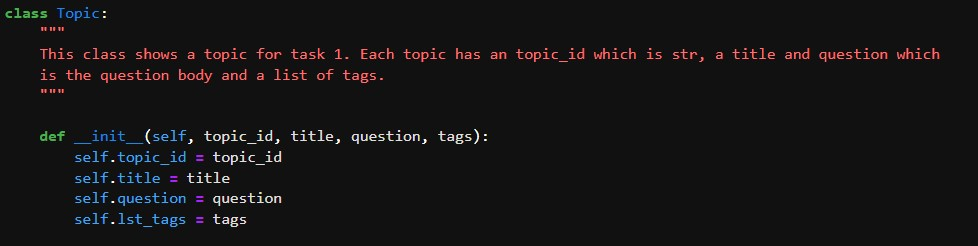

### Init Model (Can change to custom model)

In [17]:
word_embedding_model = models.Transformer(model_name, max_seq_length=512)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode="mean")
IR_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [18]:
IR_model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: AlbertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

### Parsing our topics (or Queries)

In [19]:
from ARQMathCode.topic_file_reader import TopicReader
import ARQMathCode

def set_query_question(query : ARQMathCode.topic_file_reader.Topic, text):
    query.question = text
    return query

topic_filepath = "data/Topics_Task1_2022_V0.1.xml"
topic_records = TopicReader(topic_filepath)
topic_parser = BlankSubstituer._drop_xml_tags
topics_map = map(lambda a : 
                 set_query_question(a[1], topic_parser(a[1].question))
                 , topic_records.map_topics.items())
topics_records = list(topics_map)

### Methods: Storing Corpus on Disk, Searching via Query

In [44]:
# Storing the Corpus embedding in chunks
def store_corpus_embeddings(corpus_data, 
                            chunk_size=100000,
                            batch_size=32):
    corpus = list(map(lambda x: x.texts[1], all_data))
    datalength = len(corpus)
    ct = 1
    for i in range(0, datalength, chunk_size):
        print(f"Embedding Corpus Chunk {ct}")
        embeddings_curr = IR_model.encode(corpus[i:i+chunk_size], 
                                          batch_size=batch_size,
                                          show_progress_bar=True,
                                          convert_to_tensor=True)
        object_name = f"./corpus-data/{model_name_path}-{num}/corpus-data-{ct}.pt"
        directory = f"./corpus-data/{model_name_path}-{num}/"
        if not os.path.exists(directory):
            os.mkdir(directory)
        torch.save(embeddings_curr, object_name)
        ct += 1
        embeddings_curr.detach()
        del embeddings_curr
        torch.cuda.empty_cache()

In [45]:
# Function to Return Top K results for a query
def search_from_query(query: ARQMathCode.topic_file_reader.Topic, 
                      chunk_size=100000,
                      k=100,
                      device="cuda",
                      write_csv : bool = True):
    question = query.question
    query_id = query.topic_id
    query_embedding = IR_model.encode(question, convert_to_tensor=True)
    _=query_embedding.to(device)
    results = []
    directory = f"./corpus-data/{model_name_path}-{num}/"
    ct = 0
    for filename in os.listdir(directory):
        if "corpus-data" in filename:
            corpus_embedding = torch.load(os.path.join(directory, filename))
            corpus_embedding = corpus_embedding.to(device)
            cos_scores = cos_sim(query_embedding, corpus_embedding)[0]
            topk = torch.topk(cos_scores, k=k)
            topk_score = topk[0].cpu().tolist()
            topk_idx = functorch.vmap(lambda x: x+ct*chunk_size)(topk[1])
            topk_idx = topk_idx.cpu().tolist()
            for score, idx in zip(topk_score, topk_idx):
                heapq.heappush(results, (socre, idx))
            ct += 1
            del corpus_embedding
    top_results = heapq.nlargest(k, results)
    if write_csv:
        with open(f"query-{query_id}.tsv", "w") as csvfile:
            csv_writer = csv.writer(csvfile, delimiter='\t')
            csv_writer.writerow(["pid","doc","score"])
            for score, idx in top_results:
                doc_text = all_data[idx].texts[1]
                csv_writer.writerow([idx, doc_text, score])

### Example Query

In [ ]:
chunk_size = 100000
store_corpus_embeddings(all_data, chunk_size=chunk_size, batch_size=128)

Embedding Corpus Chunk 1


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
query_num = 0
query = topics_records[query_num]
search_from_query(query, k=100, chunk_size=chunk_size, write_csv=True)

In [ ]:
# query_tokens = tokenizer(topics_records[0]["question"], all_data[0].texts[1], 
#                          truncation=True,
#                          padding="max_length",
#                          return_tensors="pt")
# query_tokens.to(device)
# query_embed = model(**query_tokens)
# torch.softmax(query_embed, dim=1).tolist()

### Old Model Training Code - CompuBERT

In [13]:
# # CompuBERT Base Model
# device = "cuda"
# model = SentenceTransformer("bert-base-wikipedia-sections-mean-tokens", 
#                             device="cuda")

In [ ]:
# This is Unused code to train using the sentence-transformers module


# Create the Sentence label dataset
train_data = SentenceLabelDataset(X_train_set, 2)

# # Create the sentences for the evaluator
# # The dataset we use for the evaluator is the dev set
# # The format for the evaluator changed since the last CompuBERT updated
# # I augmented the code to account for this change in the new
# # sentence-transformers package
# sentences_1 = [tokenizer(x.texts[0]) for x in X_dev_set]
# sentences_2 = [tokenizer(x.texts[1]) for x in X_dev_set]
# scores = [float(x.label) for x in X_dev_set]

# Load the data loader for pytorch training
# train_loader = DataLoader(dataset, batch_size=10, shuffle=False)
# train_loss = losses.CosineSimilarityLoss(model=model)

# # Init the evaluator
# # The evaluator will automatically write results to a folder
# evaluator = ArqmathEvaluator(model, sentences_1, sentences_2, scores,
#                              batch_size=10,
#                              post_parser_postproc=postproc_parser,
#                              name = "ARQMathEvaluator",
#                              show_progress_bar=True,
#                              write_csv=True
#                             )

# # Run the experiment
# experiment_num = 2
# model.compile(optimizer=Adam(3e-5))
# model.fit(train_objectives=[(train_loader, train_loss)],
#           evaluator=evaluator,
#           epochs=10,
#           evaluation_steps=50,
#           output_path=f"Math-IR-System-Experiment-{experiment_num}",
#           optimizer_params={'lr': 2e-5, 'eps': 1e-6})